In [ ]:
#!wget https://github.com/DeepQuestAI/Fire-Smoke-Dataset/releases/download/v1/FIRE-SMOKE-DATASET.zip
#!unzip FIRE-SMOKE-DATASET.zip

In [ ]:
#import shutil
#shutil.rmtree('Dataset-3/Test/Smoke')
#shutil.rmtree('/content/FIRE-SMOKE-DATASET/Train/Smoke')

In [1]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
TRAINING_DIR = "Dataset-3/Train"

training_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.15, horizontal_flip=True, fill_mode='nearest')

VALIDATION_DIR = "Dataset-3/Test"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	shuffle = True,
	class_mode='categorical',
  batch_size = 128
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
	shuffle = True,
  batch_size= 14
)

2023-01-15 23:00:06.235365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 23:00:06.428747: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-15 23:00:06.433058: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-15 23:00:06.433077: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout

input_tensor = Input(shape=(224, 224, 3))

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

2023-01-15 23:00:17.045521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 23:00:17.046014: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-15 23:00:17.046104: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-15 23:00:17.046170: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-15 23:00:17.046230: W tensorflow/c

87910968/87910968 [==============================] - 153s 2us/step


In [3]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<=0.1099 and logs.get('loss')<=0.1099):
      print('\n\n Reached The Destination!')
      self.model.stop_training = True
callbacks = myCallback()

history = model.fit(
    train_generator,
    steps_per_epoch = 14,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 14,
    callbacks=[callbacks]
)

Epoch 1/20
14/14 [==============================] - 81s 6s/step - loss: 10.3192 - acc: 0.7578 - val_loss: 0.1219 - val_acc: 0.9541
Epoch 2/20
14/14 [==============================] - 78s 6s/step - loss: 0.1396 - acc: 0.9438 - val_loss: 0.1155 - val_acc: 0.9592
Epoch 3/20
14/14 [==============================] - 73s 5s/step - loss: 0.5206 - acc: 0.8487 - val_loss: 0.1148 - val_acc: 0.9643
Epoch 4/20
14/14 [==============================] - 72s 5s/step - loss: 0.1477 - acc: 0.9516 - val_loss: 0.3175 - val_acc: 0.8418
Epoch 5/20
14/14 [==============================] - 75s 6s/step - loss: 0.1101 - acc: 0.9581 - val_loss: 0.2206 - val_acc: 0.9082
Epoch 6/20
14/14 [==============================] - ETA: 0s - loss: 0.0720 - acc: 0.9707

 Reached The Destination!
14/14 [==============================] - 79s 6s/step - loss: 0.0720 - acc: 0.9707 - val_loss: 0.0986 - val_acc: 0.9643


In [4]:

for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])


class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<=0.1099 and logs.get('loss')<=0.1099):
      print('\n\n Reached The Destination!')
      self.model.stop_training = True
callbacks = myCallback()

history = model.fit(
    train_generator,
    steps_per_epoch = 14,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = 14,
    callbacks=[callbacks]
)
print(len(base_model.layers))

Epoch 1/10
14/14 [==============================] - 94s 6s/step - loss: 0.2081 - acc: 0.9103 - val_loss: 0.3098 - val_acc: 0.9235
Epoch 2/10
14/14 [==============================] - 87s 6s/step - loss: 0.0496 - acc: 0.9821 - val_loss: 0.1246 - val_acc: 0.9694
Epoch 3/10
14/14 [==============================] - 87s 6s/step - loss: 0.0137 - acc: 0.9970 - val_loss: 0.1763 - val_acc: 0.9541
Epoch 4/10
14/14 [==============================] - 87s 6s/step - loss: 0.0076 - acc: 0.9988 - val_loss: 0.1990 - val_acc: 0.9490
Epoch 5/10
14/14 [==============================] - 77s 5s/step - loss: 0.0036 - acc: 0.9994 - val_loss: 0.2099 - val_acc: 0.9439
Epoch 6/10
14/14 [==============================] - 87s 6s/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.1484 - val_acc: 0.9592
Epoch 7/10
14/14 [==============================] - 92s 7s/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.1185 - val_acc: 0.9643
Epoch 8/10
14/14 [==============================] - ETA: 0s - loss: 0.0015 - acc: 0.9994



In [5]:
model.save('InceptionV3.h5')

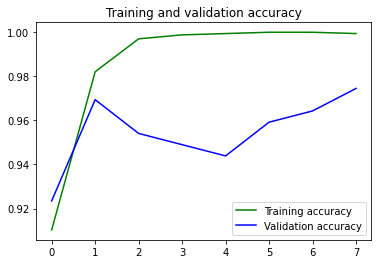

<Figure size 432x288 with 0 Axes>

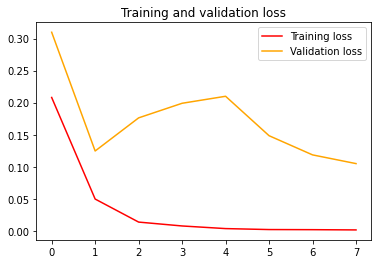

<Figure size 432x288 with 0 Axes>

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')

plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
#predicting any random image
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0) /255
  classes = model.predict(x)
  print(np.argmax(classes[0])==0, max(classes[0]))